In [378]:
import json
import matplotlib.pyplot as plt
from os import walk
import numpy as np
import pandas as pd
from os import listdir
from os.path import isfile, join
from tensorflow.keras import Sequential, layers, Model
from tensorflow import keras
from tensorflow.keras.optimizers.schedules import CosineDecay
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model
# path_processed = '/Users/armandovieira/Projects/IAEA/selected_training_spectra/'
# path_synth = '/Users/armandovieira/Projects/IAEA/selected_training_spectra//data/selected_15_in_synthetic.csv'
# path_origin = '/Users/armandovieira/Projects/IAEA/selected_training_spectra/data/selected_15_in_data.csv'
path_processed = '/Users/armandovieira/Projects/IAEA/4e/'
path_synth = '/Users/armandovieira/Projects/IAEA/4e/data/4e_in_synthetic.csv'
path_origin = '/Users/armandovieira/Projects/IAEA/4e/data/4e_in_data.csv'
pd.set_option('display.max_rows', 100)
import seaborn as sns

In [4]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set_style("darkgrid")
font = {'family' : 'arial',
        'weight' : 'bold',
        'size'   : 40}
plt.rc('font', **font)
# sns.set(rc=font)

In [379]:
N_files = 10000+216
files = [f for f in listdir(path_processed) if isfile(join(path_processed, f))]
files = [f for f in files if f.split(".")[-1]=='dat']
data_nuno = {}

for f in files[:]:
    temp = pd.read_csv(join(path_processed, f),header=None).iloc[:,-1]#.reset_index()
    data_nuno[f] = temp.apply(lambda x: x.split()[-1]).reset_index().iloc[:,-1].astype('float')

data_nuno = pd.DataFrame.from_dict(data_nuno).T.astype('float')
# data_nuno.columns = ['a'+str(i) for i in range(data_nuno.shape[1])]
data_nuno.index=[x.split(".")[0] for x in files[:]]
data_nuno = data_nuno.sort_index(ascending=True).iloc[:N_files]
print(data_nuno.shape)

(10216, 414)


<AxesSubplot:>

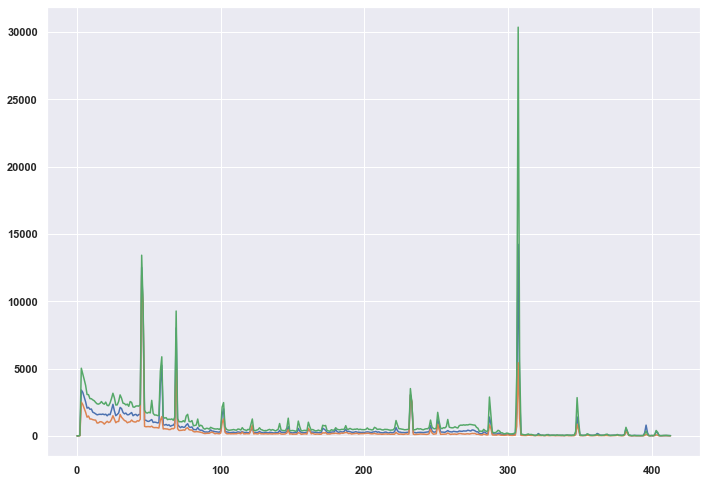

In [285]:
# psynth = pd.read_csv('/Users/armandovieira/Projects/IAEA/4a/data/4a_in_synthetic.csv',sep=";")
# psynth = psynth.reset_index()
# psynth[psynth.Se>1.1]['Se']
data_nuno.iloc[10].plot()
data_nuno.iloc[8].plot()
data_nuno.iloc[13].plot()

In [380]:
cols = ['Se','UNC','LOD','SAMPLE MASS','FILL','CMP']

psynth = pd.read_csv(path_synth,sep=";").iloc[:N_files-216]
psynth = psynth.reset_index()
# psynth

In [365]:
# p.Se.hist(alpha=.5)
# psynth.Se.sample(p.shape[0]).hist(alpha=.5)
# data_nuno.iloc[0][:20]
# p[cols]

In [381]:
cols = ['Se','UNC','LOD','SAMPLE MASS','FILL','CMP']
p = pd.read_csv(path_origin,sep=";")

# psynth = pd.read_csv('/Users/armandovieira/Projects/IAEA/2_in_synthetic.csv',sep=";")
ptotal = pd.concat([p[cols],psynth[cols]],axis=0)
df = pd.concat([ptotal.reset_index(),data_nuno.reset_index()],axis=1)
df = df.drop(columns='index')
df.isna().sum().sum()
# df=df.iloc[:,[0,1,2,3,4,5,15,17,79,80]]
print(df.shape)

(10216, 420)


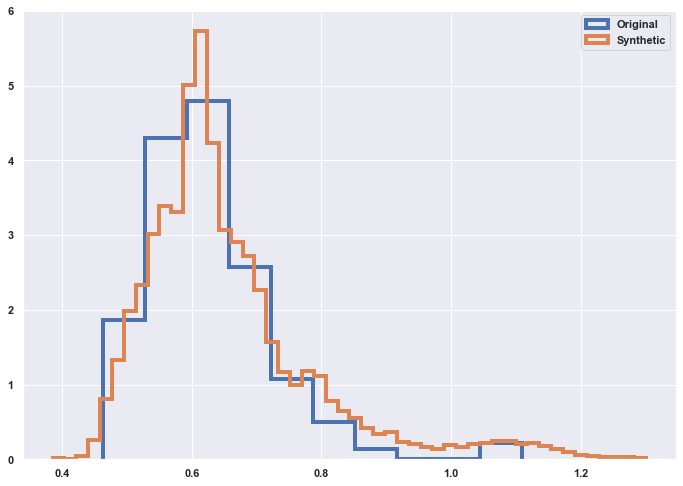

In [382]:
df[cols]=df[cols].fillna(0).astype('float')

df.iloc[:216].Se.hist( histtype="step", density=True, lw=4, label="Original",bins=10)
df.iloc[216:].Se.hist( histtype="step", density=True, lw=4, label="Synthetic",bins=50)
plt.legend()

In [383]:
trainx = df.iloc[:,3:].astype('float')
trainx[trainx>10000] = trainx[trainx>10000].apply(lambda x: 10000+np.power(x,.2))
trainx = trainx.apply(lambda x: x/(.0001+x.max()))
trainy = df.iloc[:,:3].astype('float').fillna(0)

min_o = trainy.min()
max_o = trainy.max()
trainy = (trainy - trainy.min())/(trainy.max()-trainy.min())
trainx = trainx.astype('float')
trainx.shape

(10216, 417)

In [103]:
# df.isna().sum().sum()
# df.iloc[:,:3]
# trainy = df.iloc[:,:3]
# trainy.isna().sum().sum()
# trainy = (trainy - trainy.min())/(trainy.max()-trainy.min())
# trainy.min()

In [387]:
#N_files = 2000
mask = list(np.arange(0,171))+list(np.arange(216,10000))
mask_test = list(np.arange(172,216))
# trainx_,testx, trainy_,  testy = train_test_split(trainx,trainy,test_size=0.2)
# initial = 216
# final = 1216
# # trainx_,testx, trainy_,  testy = trainx[initial:], trainx[150:initial], trainy.iloc[initial:],  trainy.iloc[150:initial]
trainx_,testx, trainy_,  testy = trainx.values[mask], trainx.values[mask_test], trainy.values[mask],  trainy.values[mask_test]
# trainx_,testx, trainy_,  testy = trainx[:150], trainx[150:initial], trainy.iloc[:150],  trainy.iloc[150:initial]

Epoch 00390: early stopping
1/1 [==============================] - 0s 264ms/step - loss: 0.0021 - dense_502_loss: 4.7606e-04 - dense_503_loss: 0.0055 - dense_504_loss: 0.0024
[0.002065117470920086, 0.00047606119187548757, 0.005496453959494829, 0.002448827726766467]


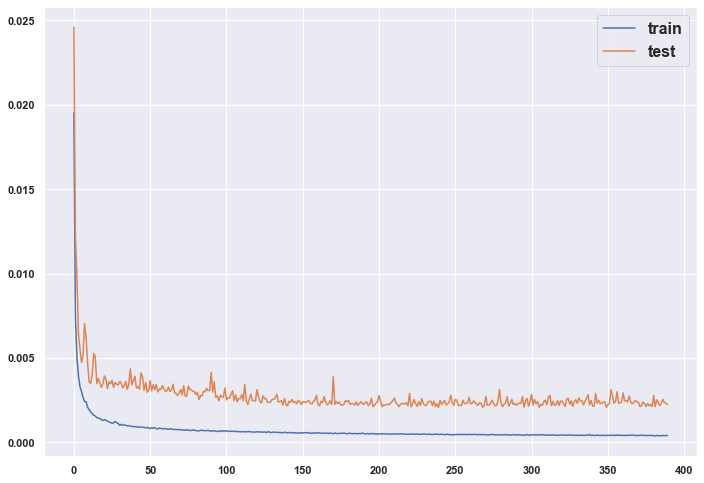

In [392]:
activation = 'gelu'
l=[]
num_patches = 3
num_embeddings = 10

xinput1 = layers.Input(shape=(trainx.shape[1],), name='input_c')

patch_size = int(xinput1.shape[1]//num_patches)

for i in range(num_patches):
    x = layers.Dense(num_embeddings, activation=activation)(xinput1[:,patch_size*i : patch_size*(i+1)])
    s = layers.Dense(2, activation = activation)(xinput1[:,:3])
    x = layers.concatenate([x,s])
    x = layers.Dropout(.01)(x)
    l.append(x)
x = layers.concatenate(l)

# x = layers.Dense(30, activation=activation)(xinput1)
x = layers.Dense(30, activation=activation)(x)
x = layers.Dropout(.01)(x)
x = layers.Dense(10, activation=activation)(x)
#y = layers.Dense(trainy.shape[1])(x) 
y = [layers.Dense(1)(x)  for _ in range(trainy.shape[1])]

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=150)
mc = ModelCheckpoint('best_model_4e.h5', monitor='val_loss', mode='min', verbose=0, save_best_only=True)

model = Model(xinput1,y)
# model = Model([xinput1],[y1])
model.compile(loss='mse', optimizer='adam', loss_weights=[1.,.2,.2])
# model.summary()
history = model.fit([trainx_], 
                    [trainy_[:,0],trainy_[:,1],trainy_[:,2]],
                    validation_data = ([testx],[testy[:,0],testy[:,1],testy[:,2]]), 
                    epochs=2000, 
                    batch_size=10, 
                    verbose=False,
                    callbacks=[es,mc])

plt.plot(history.history['loss'], label ="train")
plt.plot(history.history['val_loss'], label ="test")
plt.legend(prop={'size': 16})

model = load_model('best_model_4e.h5')
# print(model.evaluate([trainx_], [trainy_], batch_size=100))
print(model.evaluate([testx]  , [testy[:,0],testy[:,1],testy[:,2]], batch_size=100))

In [167]:
import lightgbm as lgb
lgb_train = lgb.Dataset(trainx_, trainy_[:,0])
lgb_eval = lgb.Dataset(testx, testy[:,0], reference=lgb_train)
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': {'rmse'},
    'num_leaves': 20,
    'learning_rate': 0.03,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0
}

gbm = lgb.train(params,
                lgb_train,
                num_boost_round=500,
                valid_sets=lgb_eval,
                callbacks=[lgb.early_stopping(stopping_rounds=5)])

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001040 seconds.
You can set `force_col_wise=true` to remove the overhead.
[1]	valid_0's rmse: 0.109777
Training until validation scores don't improve for 5 rounds
[2]	valid_0's rmse: 0.108975
[3]	valid_0's rmse: 0.108297
[4]	valid_0's rmse: 0.107628
[5]	valid_0's rmse: 0.107134
[6]	valid_0's rmse: 0.106194
[7]	valid_0's rmse: 0.105163
[8]	valid_0's rmse: 0.10421
[9]	valid_0's rmse: 0.103968
[10]	valid_0's rmse: 0.102711
[11]	valid_0's rmse: 0.102508
[12]	valid_0's rmse: 0.102397
[13]	valid_0's rmse: 0.10226
[14]	valid_0's rmse: 0.101629
[15]	valid_0's rmse: 0.101597
[16]	valid_0's rmse: 0.100916
[17]	valid_0's rmse: 0.100581
[18]	valid_0's rmse: 0.100084
[19]	valid_0's rmse: 0.0995319
[20]	valid_0's rmse: 0.0988279
[21]	valid_0's rmse: 0.0981343
[22]	valid_0's rmse: 0.0979099
[23]	valid_0's rmse: 0.0972248
[24]	valid_0's rmse: 0.0964193
[25]	valid_0's rmse: 0.0966838
[26]	valid_0's rmse: 0.096078

<AxesSubplot:>

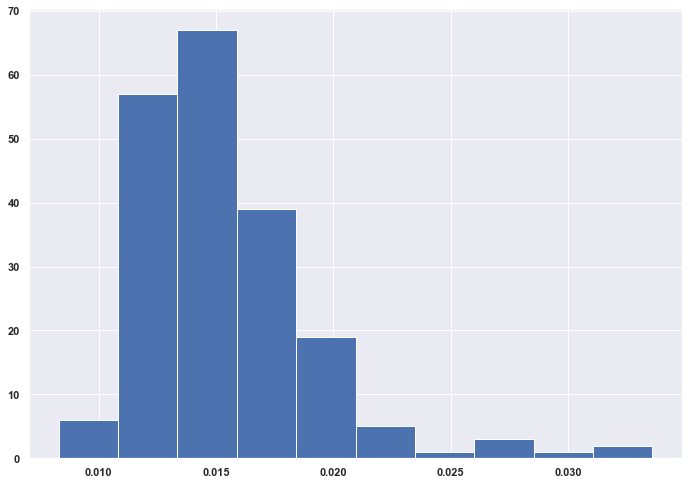

In [179]:
df.iloc[:200].UNC.hist()

In [173]:
model = load_model('best_model_5.h5')
print(model.evaluate([testx], [testy[:,0],testy[:,1],testy[:,2]], batch_size=100))
print(model.evaluate([trainx_]  , [trainy_[:,0],trainy_[:,1],trainy_[:,2]], batch_size=100))

1/1 [==============================] - 0s 183ms/step - loss: 5.1209e-04 - dense_194_loss: 1.9904e-04 - dense_195_loss: 0.0062 - dense_196_loss: 0.0025
[0.0005120864370837808, 0.00019904487999156117, 0.006239559501409531, 0.0025064595974981785]
102/102 [==============================] - 0s 1ms/step - loss: 4.5397e-04 - dense_194_loss: 2.3906e-04 - dense_195_loss: 0.0057 - dense_196_loss: 0.0016
[0.00045396832865662873, 0.00023905604030005634, 0.005706869997084141, 0.0015784358838573098]


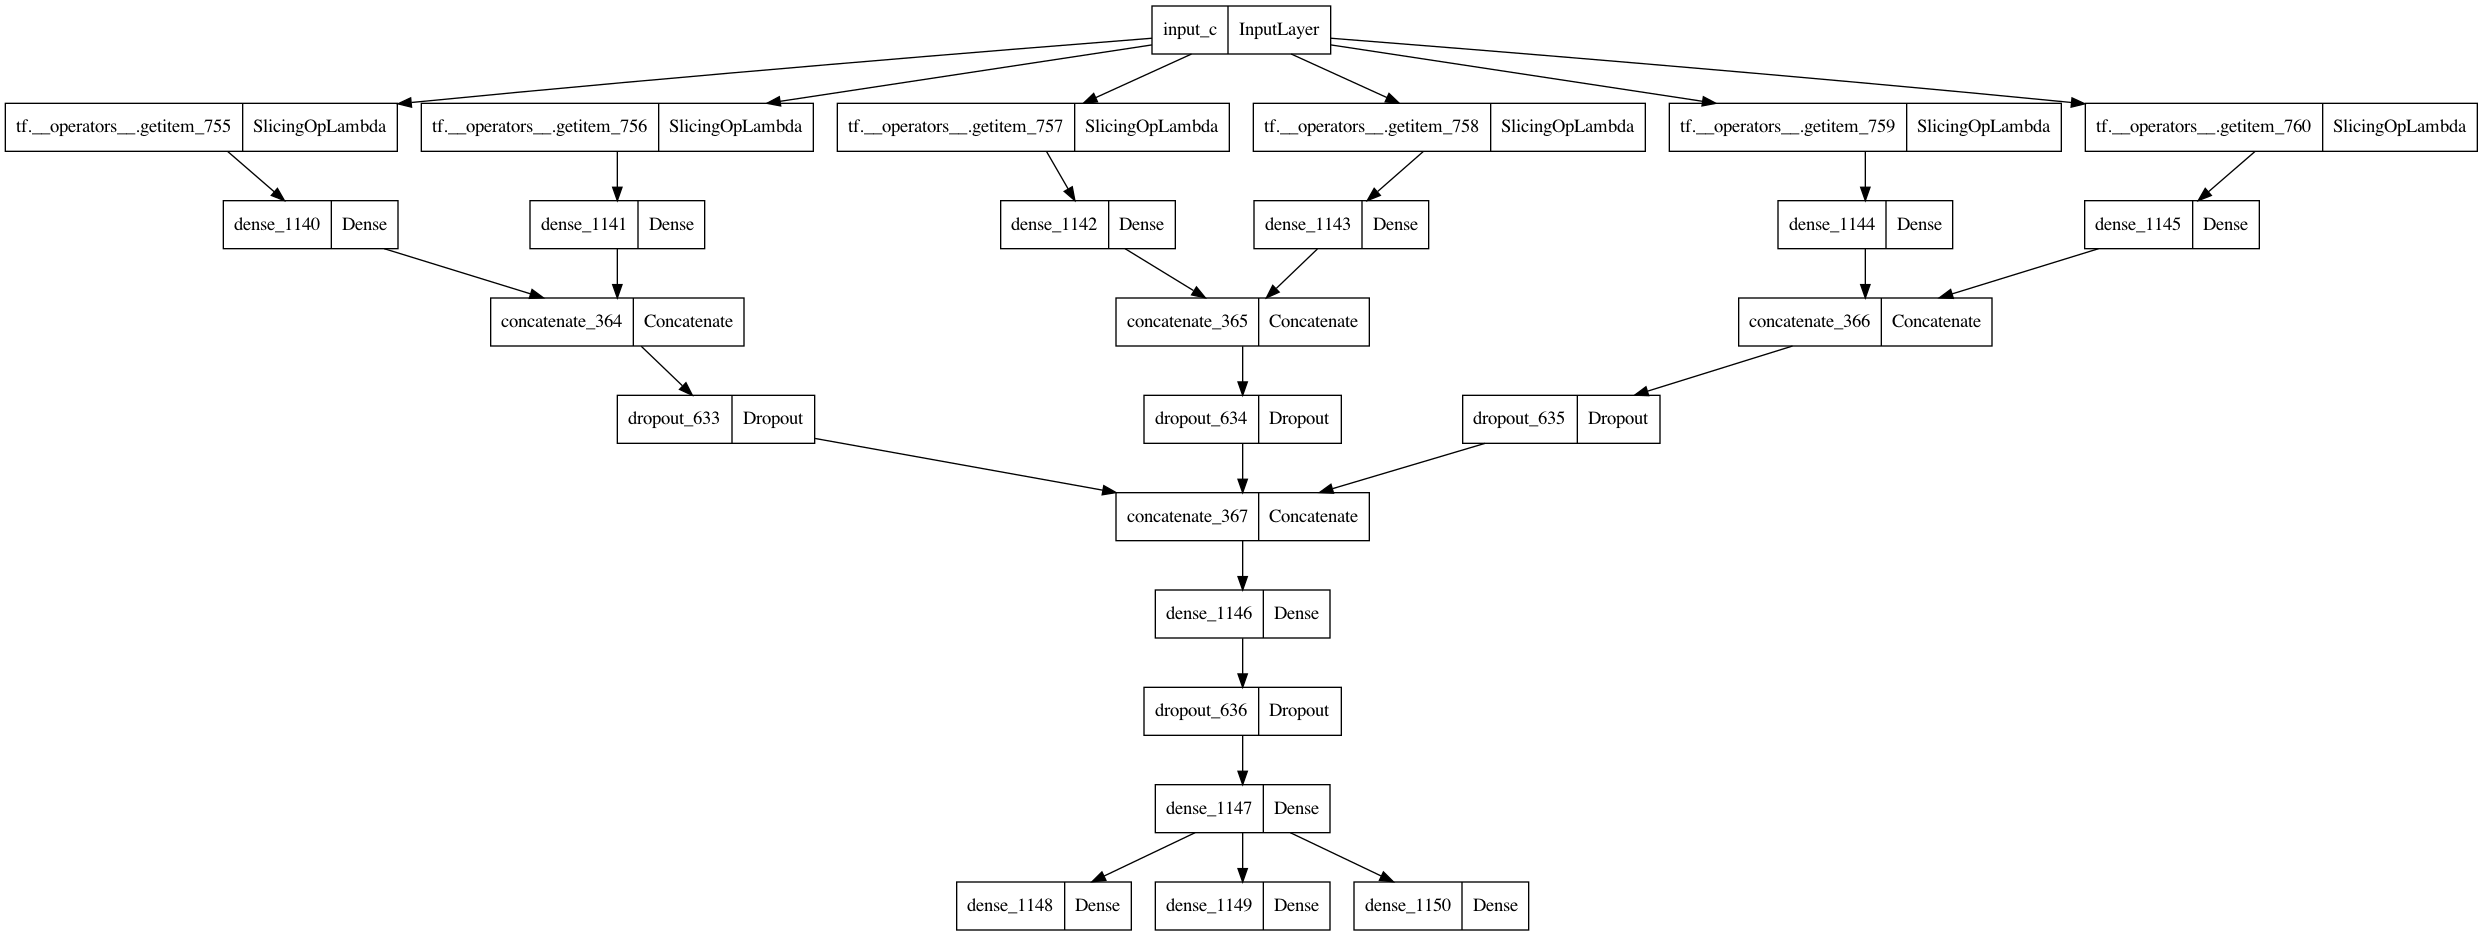

In [13]:
tf.keras.utils.plot_model(
    model,
    to_file="model.png",
    show_shapes=False,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=False,
)

## results 
| train | test 
only real data: test:
0.07
gelu/ block / 200 epocs / test: 150 - 216, train 216 - 1216
.0007 , .0034
gelu/ block / 200 epocs / test: 150 - 216, train 216 - 1216
.0007 , .0034
gelu/ block / 200 epocs / test: 150 - 216, train 216 - 1216 data_4a
.0012 , .0069
gelu/ block / layernorm, 200 epocs / test: 150 - 216, train 216 - 1216 data
.0012 , .0072


In [263]:
df['LOD'].astype('float').describe()

count    10160.000000
mean         0.029815
std          0.015512
min          0.009300
25%          0.020100
50%          0.025290
75%          0.033943
max          0.099660
Name: LOD, dtype: float64

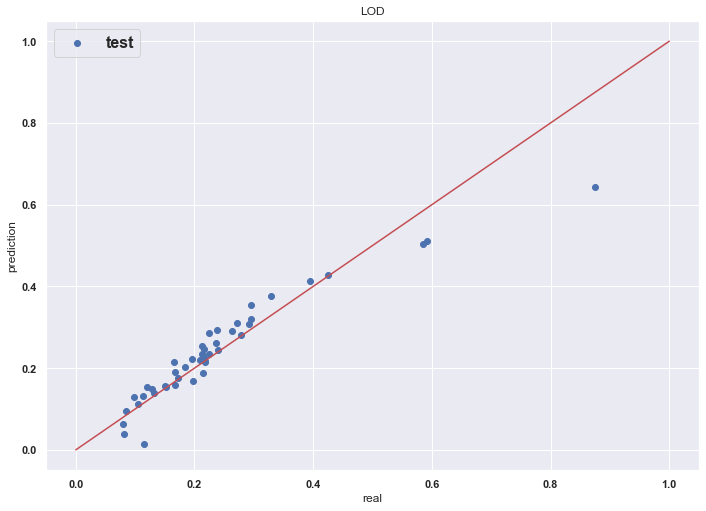

In [397]:
#plt.figure(figsize=(12,10))
i=2
plt.scatter(trainy_[:,i], model.predict(trainx_)[i][:], label="train")
plt.scatter(testy[:,i], model.predict(testx)[i][:],     label="test" )
# plt.scatter(trainy_['Se'].values, model.predict(trainx_)[:,0], label="train")
# plt.scatter(testy['Se'].values, model.predict(testx)[:,0],     label="test" )
# plt.scatter(testy['LOD'].values, model.predict(testx)[:,2])
# plt.scatter(testy['UNC'].values, model.predict(testx)[:,1])
plt.title('LOD')
plt.ylabel('prediction')
plt.xlabel('real')
plt.legend(prop={'size': 16})
x = np.linspace(.0,1.,100)
y = x
plt.plot(x, y, '-r')

In [239]:
results.columns

Index(['spectra', 'Se_normalized_real', 'LOD_normalized_predicted',
       'LOD_normalized_real', 'UNC_normalized_predicted',
       'UNC_normalized_real', 'Se_normalized_predicted', 'Se_real'],
      dtype='object')

In [398]:
predicted = model.predict(trainx)
results = pd.DataFrame()
results['spectra']= data_nuno.index
# results['Se_real_normalized']= trainy['Se']
results['Se_real']= trainy['Se']*(max_o['Se'] - min_o['Se'])+min_o['Se']
results['Se_predicted']= predicted[0]*(max_o['Se'] - min_o['Se'])+min_o['Se']
results['LOD_real']= trainy['LOD']*(max_o['LOD'] - min_o['LOD'])+min_o['LOD']
results['LOD_predicted']= predicted[1]*(max_o['LOD'] - min_o['LOD'])+min_o['LOD']
results['UNC_real']= trainy['UNC']*(max_o['UNC'] - min_o['UNC'])+min_o['UNC']
results['UNC_predicted']= predicted[2]*(max_o['UNC'] - min_o['UNC'])+min_o['UNC']
results['mask']='train'
results.loc[mask_test,'mask']='test'
results['ratio']  = (results['Se_predicted']/results['Se_real'])

In [408]:
results[results['mask']=='test']

,spectra,Se_real,Se_predicted,LOD_real,LOD_predicted,UNC_real,UNC_predicted,mask,ratio
172,4e_data_00173,0.606,0.622766,0.0290,0.044137,0.0142,0.008119,test,1.027666
173,4e_data_00174,0.662,0.636755,0.0165,0.038454,0.0139,0.002366,test,0.961865
174,4e_data_00175,0.765,0.746884,0.0167,0.040468,0.0143,0.001457,test,0.976319
175,4e_data_00176,0.718,0.692200,0.0285,0.048820,0.0164,0.008892,test,0.964066
176,4e_data_00177,0.659,0.652329,0.0310,0.047824,0.0159,0.009296,test,0.989877
177,4e_data_00178,0.635,0.627203,0.0345,0.049842,0.0202,0.010653,test,0.987722
178,4e_data_00179,0.537,0.550096,0.0202,0.037687,0.0120,0.005835,test,1.024387
179,4e_data_00180,0.598,0.603312,0.0170,0.038053,0.0116,0.003652,test,1.008883
180,4e_data_00181,0.531,0.557788,0.0271,0.044487,0.0129,0.008427,test,1.050448
181,4e_data_00182,0.676,0.693507,0.0886,0.070270,0.0336,0.024403,test,1.025897


In [403]:
results.to_csv('/Users/armandovieira/Projects/IAEA/results_4e.csv',index=False)

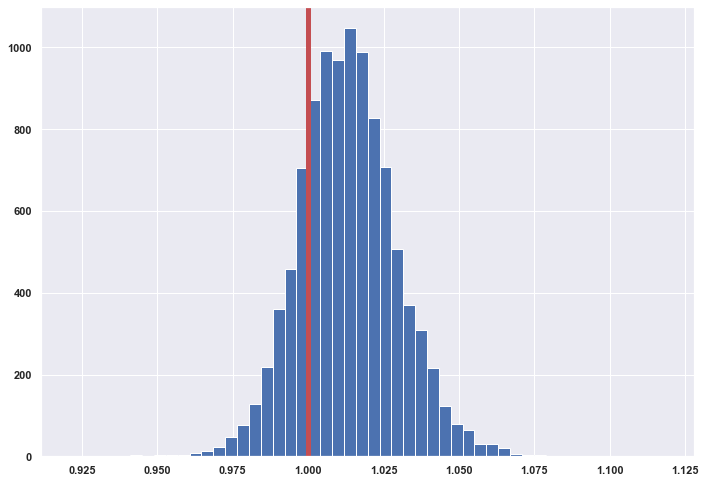

In [399]:
(results['Se_predicted']/results['Se_real']).hist(bins=50)
plt.axvline(x=1,c='r',lw=5)

In [524]:
results[results['mask']=='test']

,spectra,Se_normalized_real,Se_normalized_predicted,Se_real,Se_predicted,mask,ratio
150,4b_data_00151,0.424223,0.419922,0.793,0.788959,test,0.994904
151,4b_data_00152,0.310345,0.318866,0.686,0.694006,test,1.011671
152,4b_data_00153,0.189017,0.185841,0.572,0.569016,test,0.994784
153,4b_data_00154,0.324181,0.332435,0.699,0.706756,test,1.011095
154,4b_data_00155,0.231588,0.217762,0.612,0.599009,test,0.978774
155,4b_data_00156,0.206045,0.203071,0.588,0.585205,test,0.995247
156,4b_data_00157,0.153895,0.160107,0.539,0.544837,test,1.010829
157,4b_data_00158,0.073010,0.073612,0.463,0.463566,test,1.001222
158,4b_data_00159,0.129417,0.134152,0.516,0.520449,test,1.008622
159,4b_data_00160,0.231588,0.235187,0.612,0.615382,test,1.005526


In [81]:
pd.set_option('display.max_rows', 100)
results[results['mask']=='test']

,spectra,Se_normalized_real,Se_normalized_predicted,Se_real,Se_predicted,mask
150,4a_data_0151,0.475921,0.475013,0.793,0.792359,test
151,4a_data_0152,0.324363,0.310527,0.686,0.676232,test
152,4a_data_0153,0.162890,0.191305,0.572,0.592062,test
153,4a_data_0154,0.342776,0.333717,0.699,0.692604,test
154,4a_data_0155,0.219547,0.233437,0.612,0.621806,test
155,4a_data_0156,0.185552,0.216361,0.588,0.609751,test
156,4a_data_0157,0.116147,0.154706,0.539,0.566222,test
157,4a_data_0158,0.008499,0.067572,0.463,0.504706,test
158,4a_data_0159,0.083569,0.122757,0.516,0.543666,test
159,4a_data_0160,0.219547,0.241607,0.612,0.627575,test


In [536]:
plt.legend?

Signature: plt.legend(*args, **kwargs)
Docstring:
Place a legend on the axes.

Call signatures::

    legend()
    legend(labels)
    legend(handles, labels)

The call signatures correspond to three different ways how to use
this method.

**1. Automatic detection of elements to be shown in the legend**

The elements to be added to the legend are automatically determined,
when you do not pass in any extra arguments.

In this case, the labels are taken from the artist. You can specify
them either at artist creation or by calling the
:meth:`~.Artist.set_label` method on the artist::

    line, = ax.plot([1, 2, 3], label='Inline label')
    ax.legend()

or::

    line, = ax.plot([1, 2, 3])
    line.set_label('Label via method')
    ax.legend()

Specific lines can be excluded from the automatic legend element
selection by defining a label starting with an underscore.
This is default for all artists, so calling `.Axes.legend` without
any arguments and without setting the labels manually will

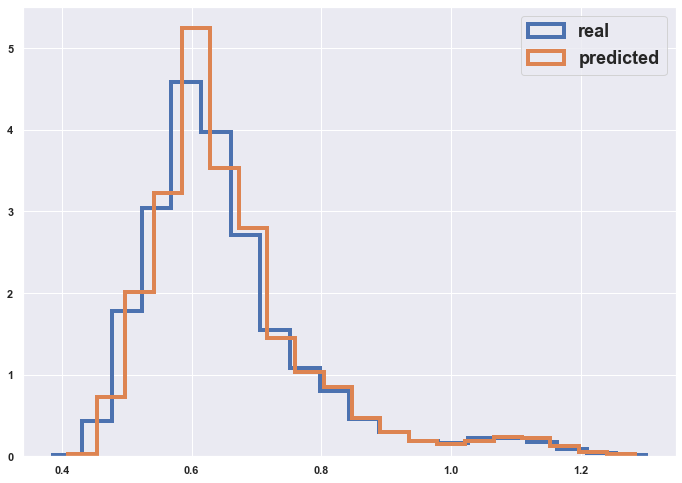

In [402]:
# results[results['mask']=='train']['Se_real'].hist(alpha=.5,bins=20,label = 'real')
# results[results['mask']=='train']['Se_predicted'].hist(alpha=.5,bins=19, label = "predicted")
results[results['mask']=='train']['Se_real'].hist(histtype="step", density=True, lw=4, label = 'real', bins=20)
results[results['mask']=='train']['Se_predicted'].hist(histtype="step", density=True, lw=4,  label = "predicted", bins=20)

 
plt.legend(fontsize=18)

In [303]:
import seaborn as sns

In [437]:
data = pd.DataFrame()
data['Error'] = [0.0020, 0.0018, 0.00074, 0.00046]
data['N_points'] = [0,1000,3000,10000]

In [584]:
dd=pd.DataFrame()
dl = []
d = [0.002, 0.0015, 0.00074, 0.00046]
n = [0,1000,3000,10000]
for i, x in enumerate(d):
    for j in range(10):
        a=x
        a=a*np.random.uniform(.8,1.2)+np.random.uniform(-.0002,.0002)
        dl.append([n[i],j,a])
dd = pd.DataFrame(dl,columns=['N_points','exp','Se'])
dda = dd.groupby(['exp','N_points']).mean().unstack().mean(axis=0)

dd1 = data.copy()
dd1['Error']=dda.values

[Text(0.5, 1.0, 'MSE')]

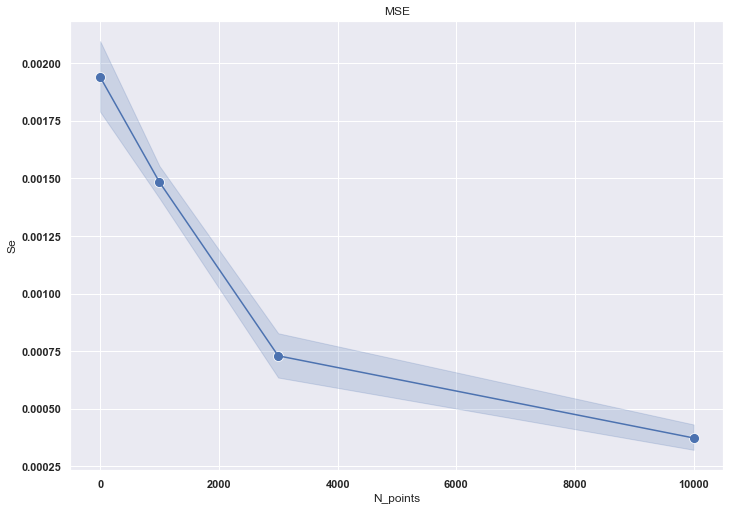

In [585]:
ax = sns.lineplot(y="Se", x="N_points", data=dd, markers=True)
ax = sns.scatterplot(y="Error", x="N_points", data=dd1, s=100)
ax.set(title='MSE')